In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [12]:
df = pd.read_csv('one_hot_encode.csv')

# Opening the original file

In [13]:
original = pd.read_csv('cleaned_data.csv')

In [14]:
original.head(2)

,title,rated,released,runtime,director,writer,actors,plot,language,country,...,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating
0,Inception,PG-13,2010-07-16,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",...,292576195.0,True,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0
1,Iron Man 2,PG-13,2010-05-07,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,...,312433331.0,True,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0


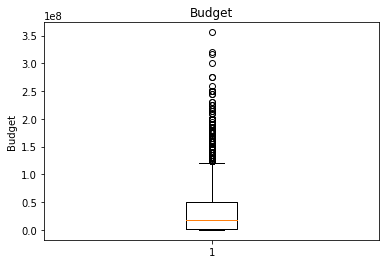

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Example outlier plot of reaction times
budgetOutl = original['budget']
fig1, ax1 = plt.subplots()
ax1.set_title('Budget')
ax1.set_ylabel('Budget')
ax1.boxplot(budgetOutl)
plt.show()

In [16]:
quartiles = np.quantile(times,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

potential_outliers = [print(time) if time < lower_bound or time > upper_bound else next for time in times]

NameError: name 'times' is not defined

In [18]:
original.columns

Index(['title', 'rated', 'released', 'runtime', 'director', 'writer', 'actors',
       'plot', 'language', 'country', 'awards', 'metascore', 'imdbrating',
       'imdbvotes', 'dvd', 'boxoffice', 'response', 'genre', 'star', 'budget',
       'gross', 'year', 'internet_movie_database_rating',
       'rotten_tomato_rating', 'metacritic_rating'],
      dtype='object')

In [19]:
attrition_cat = original.dtypes[original.dtypes == "object"].index.tolist()

In [20]:
original[attrition_cat].nunique()

title       1715
rated         10
released     759
director    1112
writer      1582
actors      1693
plot        1715
language     394
country      390
awards       705
dvd          638
genre         16
star         931
dtype: int64

# Clean the file

In [21]:
original["rated"].fillna("NA", inplace = True)
original["director"].fillna("NA", inplace = True)
original["writer"].fillna("NA", inplace = True)
original["language"].fillna("NA", inplace = True)
original["country"].fillna("NA", inplace = True)
original["awards"].fillna("NA", inplace = True)
original["metascore"].fillna(0, inplace = True)
original["dvd"].fillna("NA", inplace = True)
original["boxoffice"].fillna(0, inplace = True)
original["budget"].fillna(0, inplace = True)
original["gross"].fillna(0, inplace = True)


In [22]:
original[attrition_cat].nunique()

title       1715
rated         11
released     759
director    1113
writer      1583
actors      1693
plot        1715
language     395
country      391
awards       706
dvd          639
genre         16
star         931
dtype: int64

In [23]:
original.fillna(0, inplace=True)

# Ratings to be binned

In [24]:
original.loc[original['rated']=='TV-MA', 'rated'] = 'R'
original.loc[original['rated']=='NC-17', 'rated'] = 'R'
original.loc[original['rated']=='TV-14', 'rated'] = 'PG-13'
original.loc[original['rated']=='TV-PG', 'rated'] = 'PG'
original.loc[original['rated']=='Unrated', 'rated'] = 'NA'
original.loc[original['rated']=='Not Rated', 'rated'] = 'NA'

In [25]:
original[attrition_cat].nunique()

title       1715
rated          5
released     759
director    1113
writer      1583
actors      1693
plot        1715
language     395
country      391
awards       706
dvd          639
genre         16
star         931
dtype: int64

In [26]:
stars = original.star.value_counts()

# stars with less than 5 will be binned in other

In [27]:
stars_replace = stars[stars<5].index.to_list()
for star in stars_replace:
      original['star'] =  original['star'].replace(star,'other')

original['star'].value_counts() 

other                  1197
Mark Wahlberg            13
Liam Neeson              12
Matthew McConaughey      12
Matt Damon               12
                       ... 
Jennifer Aniston          5
Saoirse Ronan             5
Naomi Watts               5
Owen Wilson               5
Kevin Hart                5
Name: star, Length: 82, dtype: int64

In [28]:
original[attrition_cat].nunique()

title       1715
rated          5
released     759
director    1113
writer      1583
actors      1693
plot        1715
language     395
country      391
awards       706
dvd          639
genre         16
star          82
dtype: int64

# Hot encoded manually for more than one item 

In [29]:
def one_hot_encode(column,new_col_names):
    
    for index, row in original.iterrows():
        item_names=str(row[column]).split(',')
        for y in item_names:
            y=y.strip()
            if y in new_col_names:
                original.loc[index, y]=1
        

# Country

In [30]:
from collections import Counter
# Find most common country names
countries=original['country'].to_list()

country_list=[]

for x in countries:
    
        country_array = str(x).split(',')
        for y in country_array:
            y=y.strip()
            country_list.append(y)
most_common=Counter(country_list).most_common(10)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    original[item[0]]=""
one_hot_encode('country',new_col_names)

In [31]:
languages=original['language'].to_list()

language_list=[]

for x in languages:
    
        language_array = str(x).split(',')
        for y in language_array:
            y=y.strip()
            language_list.append(y)
most_common=Counter(language_list).most_common(15)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    original[item[0]]=""
one_hot_encode('language',new_col_names)

In [32]:
writers=original['writer'].to_list()

writer_list=[]

for x in writers:
    
        writer_array = str(x).split(',')
        for y in writer_array:
            y=y.strip()
            writer_list.append(y)
most_common=Counter(writer_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    original[item[0]]=""
one_hot_encode('writer',new_col_names)

In [33]:
actors=original['actors'].to_list()

actor_list=[]

for x in actors:
    
        actor_array = str(x).split(',')
        for y in actor_array:
            y=y.strip()
            actor_list.append(y)
most_common=Counter(actor_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    original[item[0]]=""
one_hot_encode('actors',new_col_names)

In [34]:
len(new_col_names)

50

In [35]:
print (new_col_names)

['Mark Wahlberg', 'Michael Fassbender', 'Liam Neeson', 'Dwayne Johnson', 'Steve Carell', 'Jennifer Lawrence', 'Owen Wilson', 'Scarlett Johansson', 'Matthew McConaughey', 'Gerard Butler', 'Matt Damon', 'Jonah Hill', 'Bradley Cooper', 'Keira Knightley', 'Ryan Reynolds', 'Emily Blunt', 'Channing Tatum', 'Chris Hemsworth', 'Tom Hardy', 'Robert Downey Jr.', 'Cate Blanchett', 'Emma Stone', 'Nicole Kidman', 'Seth Rogen', 'Anna Kendrick', 'Kevin Hart', 'Jesse Eisenberg', 'Helen Mirren', 'Robert Pattinson', 'Joel Edgerton', 'Rachel McAdams', 'Rachel Weisz', 'Naomi Watts', 'Jake Gyllenhaal', 'Hugh Jackman', 'Russell Crowe', 'Michelle Williams', 'James Franco', 'Anne Hathaway', 'Zac Efron', 'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage', 'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams', 'Robert De Niro', 'Chris Pine']


In [36]:
len(countries)

1774

In [37]:
original[attrition_cat].nunique()

title       1715
rated          5
released     759
director    1113
writer      1583
actors      1693
plot        1715
language     395
country      391
awards       706
dvd          639
genre         16
star          82
dtype: int64

In [38]:
original.nunique()

title              1715
rated                 5
released            759
runtime             105
director           1113
                   ... 
Johnny Depp           2
Kristen Stewart       2
Amy Adams             2
Robert De Niro        2
Chris Pine            2
Length: 150, dtype: int64

In [39]:
attrition_cat = original.dtypes[original.dtypes == "object"].index.tolist()

In [40]:
original[attrition_cat].nunique()

title              1715
rated                 5
released            759
director           1113
writer             1583
                   ... 
Johnny Depp           2
Kristen Stewart       2
Amy Adams             2
Robert De Niro        2
Chris Pine            2
Length: 138, dtype: int64

In [41]:
original.columns

Index(['title', 'rated', 'released', 'runtime', 'director', 'writer', 'actors',
       'plot', 'language', 'country',
       ...
       'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage',
       'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams',
       'Robert De Niro', 'Chris Pine'],
      dtype='object', length=150)

In [42]:
original['United States'].dtype

dtype('O')

In [43]:
he = original.drop(['title', 'rated', 'released', 'runtime', 'director', 'writer', 'actors',
       'plot', 'language', 'country', 'awards', 'metascore', 'imdbrating',
       'imdbvotes', 'dvd', 'boxoffice', 'response', 'genre', 'star', 'budget',
       'gross', 'year', 'internet_movie_database_rating',
       'rotten_tomato_rating', 'metacritic_rating'], axis=1)

In [44]:
he.columns

Index(['United States', 'United Kingdom', 'France', 'Canada', 'China',
       'Germany', 'Australia', 'Japan', 'India', 'Spain',
       ...
       'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage',
       'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams',
       'Robert De Niro', 'Chris Pine'],
      dtype='object', length=125)

In [45]:
he.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Columns: 125 entries, United States to Chris Pine
dtypes: object(125)
memory usage: 1.7+ MB


In [46]:
he = he.apply(pd.to_numeric) 

In [47]:
he.head()

,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,...,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
he.fillna(0, inplace=True)

In [49]:
he.head()

,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,...,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
he.astype(int)

,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,...,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1770,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1771,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1772,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
#hot encoded manualy is he and will form he1 to hot encode with hotencoder

In [52]:
original['label']=''
for index, row in original.iterrows():
    if (row['imdbrating']<5):
        original.loc[index, 'label']=0
    elif (row['imdbrating']>=5)&(row['imdbrating']<=7):
        original.loc[index, 'label']=1
    elif (row['imdbrating']>7):
        original.loc[index, 'label']=2

In [53]:
original['label'].value_counts()

1    1186
2     510
0      78
Name: label, dtype: int64

In [54]:
he1 = original[['star','rated','director','genre','label']]

In [55]:
he1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   star      1774 non-null   object
 1   rated     1774 non-null   object
 2   director  1774 non-null   object
 3   genre     1774 non-null   object
 4   label     1774 non-null   object
dtypes: object(5)
memory usage: 69.4+ KB


In [56]:
attrition_cat = he1.dtypes[he1.dtypes == "object"].index.tolist()

In [57]:
he1[attrition_cat].nunique()

star          82
rated          5
director    1113
genre         16
label          3
dtype: int64

In [58]:
directors = he1['director'].to_list()

In [59]:
directors

['Christopher Nolan',
 'Jon Favreau',
 'Martin Scorsese',
 'Edgar Wright',
 'Dennis Dugan',
 'Jim Field Smith',
 'Matthew Vaughn',
 'Darren Aronofsky',
 'Ben Affleck',
 'David Yates',
 'Rob Reiner',
 'David Fincher',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Gareth Edwards',
 'James Wan',
 'Nathan Greno, Byron Howard',
 'Robert Schwentke',
 'Steven R. Monroe',
 'M. Night Shyamalan',
 'Dean DeBlois, Chris Sanders',
 'Anton Corbijn',
 'Denis Villeneuve',
 'Michael Patrick King',
 'Steve Antin',
 'Tim Burton',
 'Pierre Coffin, Chris Renaud',
 'Ethan Coen, Joel Coen',
 'Florian Henckel von Donnersmarck',
 'David Slade',
 'Louis Leterrier',
 'Louis Leterrier',
 'Albert Hughes, Allen Hughes',
 'Derek Cianfrance',
 'James Mangold',
 'Alexandre Aja',
 'Danny Boyle',
 'Sylvester Stallone',
 'Adam McKay',
 'Joseph Kosinski',
 'Greg Berlanti',
 'Jee-woon Kim',
 'Lee Unkrich',
 'Paul Haggis',
 'Will Gluck',
 'Tom Hooper',
 'David O. Russell',
 'Ethan Maniquis, Robert Ro

# Separating director to only keep the first one

In [60]:

he1[['director1', 'director2', 'dire3']] = he1['director'].str.split(',', expand=True)

C:\Users\edipa\anaconda3\envs\tfenv\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [61]:
he1

,star,rated,director,genre,label,director1,director2,dire3
0,Leonardo DiCaprio,PG-13,Christopher Nolan,Action,2,Christopher Nolan,None,None
1,Robert Downey Jr.,PG-13,Jon Favreau,Action,1,Jon Favreau,None,None
2,Leonardo DiCaprio,R,Martin Scorsese,Mystery,2,Martin Scorsese,None,None
3,other,PG-13,Edgar Wright,Action,2,Edgar Wright,None,None
4,Adam Sandler,PG-13,Dennis Dugan,Comedy,1,Dennis Dugan,None,None
...,...,...,...,...,...,...,...,...
1769,other,NA,"Jason Kwan, Jing Wong",Action,1,Jason Kwan,Jing Wong,None
1770,other,NA,Dylan Thomas Ellis,Family,0,Dylan Thomas Ellis,None,None
1771,other,R,Jeffrey Nicholson,Action,0,Jeffrey Nicholson,None,None
1772,other,NA,David Stuart Snell,Drama,0,David Stuart Snell,None,None


In [62]:
label = he1['label']

In [63]:
he1 = he1.drop(['director2','dire3','label'], axis=1)

In [64]:
he1 = he1.drop(['director'], axis=1)

In [65]:
he1.head()

,star,rated,genre,director1
0,Leonardo DiCaprio,PG-13,Action,Christopher Nolan
1,Robert Downey Jr.,PG-13,Action,Jon Favreau
2,Leonardo DiCaprio,R,Mystery,Martin Scorsese
3,other,PG-13,Action,Edgar Wright
4,Adam Sandler,PG-13,Comedy,Dennis Dugan


In [66]:
he1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   star       1774 non-null   object
 1   rated      1774 non-null   object
 2   genre      1774 non-null   object
 3   director1  1774 non-null   object
dtypes: object(4)
memory usage: 55.6+ KB


In [67]:
attrition_cat = he1.dtypes[he1.dtypes == "object"].index.tolist()

In [68]:
he1[attrition_cat].nunique()

star           82
rated           5
genre          16
director1    1093
dtype: int64

In [69]:
direc = he1.director1.value_counts()

# Consolidating director to others 

In [70]:
direc_replace = direc[direc<5].index.to_list()
for dir in direc_replace:
      he1['director1'] =  he1['director1'].replace(dir,'other')

he1['director1'].value_counts() 

other                 1615
Ridley Scott            10
Robert Schwentke         8
NA                       8
Clint Eastwood           7
Steven Spielberg         7
Woody Allen              7
Antoine Fuqua            6
Ruben Fleischer          6
Michael Bay              5
Brad Peyton              5
Peter Berg               5
Ron Howard               5
Francis Lawrence         5
Jonathan Levine          5
Joe Wright               5
Daniel Espinosa          5
Steven Soderbergh        5
David Yates              5
Doug Liman               5
Nicholas Stoller         5
Lasse Hallström          5
Chris Buck               5
Shawn Levy               5
Paul W.S. Anderson       5
Tim Burton               5
Denis Villeneuve         5
James Wan                5
Luc Besson               5
Name: director1, dtype: int64

In [71]:
attrition_cat = he1.dtypes[he1.dtypes == "object"].index.tolist()

In [72]:
he1[attrition_cat].nunique()

star         82
rated         5
genre        16
director1    29
dtype: int64

In [73]:
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(he1[attrition_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(attrition_cat)
encode_df.head()

,star_Aaron Taylor-Johnson,star_Adam Sandler,star_Alicia Vikander,star_Andrew Garfield,star_Anna Kendrick,star_Ben Affleck,star_Ben Stiller,star_Brad Pitt,star_Bradley Cooper,star_Channing Tatum,...,director1_Ridley Scott,director1_Robert Schwentke,director1_Ron Howard,director1_Ruben Fleischer,director1_Shawn Levy,director1_Steven Soderbergh,director1_Steven Spielberg,director1_Tim Burton,director1_Woody Allen,director1_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [74]:
X = pd.merge(he,encode_df, left_index=True, right_index=True)

In [75]:
X = pd.merge(X,label, left_index=True, right_index=True)

In [76]:
X.head()

,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,...,director1_Robert Schwentke,director1_Ron Howard,director1_Ruben Fleischer,director1_Shawn Levy,director1_Steven Soderbergh,director1_Steven Spielberg,director1_Tim Burton,director1_Woody Allen,director1_other,label
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [77]:
X.columns.to_list()

['United States',
 'United Kingdom',
 'France',
 'Canada',
 'China',
 'Germany',
 'Australia',
 'Japan',
 'India',
 'Spain',
 'English',
 'Spanish',
 'French',
 'German',
 'Russian',
 'Italian',
 'Japanese',
 'Mandarin',
 'Hindi',
 'Arabic',
 'Ukrainian',
 'Korean',
 'Hebrew',
 'Swedish',
 'Latin',
 'Luc Besson',
 'Nicholas Stoller',
 'Jane Goldman',
 'Allan Loeb',
 'Stan Lee',
 'Sean Anders',
 'Brian Helgeland',
 'Cinco Paul',
 'Ken Daurio',
 'Phil Hay',
 'Sylvester Stallone',
 'Nicholas Sparks',
 'Woody Allen',
 'John Morris',
 'Matthew Vaughn',
 'Ethan Reiff',
 'Dan Fogelman',
 'Matt Manfredi',
 'Peter Straughan',
 'Mark Bomback',
 'Darren Lemke',
 'Jennifer Lee',
 'Jez Butterworth',
 'Jonathan Aibel',
 'Billy Ray',
 'Evan Daugherty',
 'Christopher Markus',
 'Stephen McFeely',
 'Steven Knight',
 'Jeff Pinkner',
 'Gary Dauberman',
 'Christopher Nolan',
 'Michael Bacall',
 'Edgar Wright',
 'Adam Sandler',
 'Leigh Whannell',
 'Joel Coen',
 'Ethan Coen',
 'Christopher McQuarrie',
 'Simo

# First try model without plot and without budget

In [78]:
Movies = X

In [79]:
Movies["label"] = Movies["label"].astype("float")

In [80]:

y = Movies['label']
x = Movies.drop('label', axis=1)

In [81]:
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Columns: 258 entries, United States to label
dtypes: float64(258)
memory usage: 3.5 MB


In [82]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=1)

In [83]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [84]:
model=RandomForestClassifier (random_state=5,n_estimators=500,max_depth=11,min_samples_split=5)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=11, min_samples_split=5, n_estimators=500,
                       random_state=5)

In [85]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [86]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.7203867848509267,testing_score:0.6941838649155723


In [87]:
len(X_train)

1241

In [ ]:
X_train.shape

In [ ]:
# Train the model
#fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

# Plot Transormation to features

In [191]:
Plot = original[['plot']]

In [192]:
Plot = Plot.replace(to_replace=',',value='', regex = True)

In [193]:
Plot['plot'] = Plot['plot'].str.replace(r'[^\w\s]+', '')

C:\Users\edipa\AppData\Local\Temp/ipykernel_1300/1660321052.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Plot['plot'] = Plot['plot'].str.replace(r'[^\w\s]+', '')


In [194]:
Plot.head(5)

,plot
0,A thief who steals corporate secrets through t...
1,With the world now aware of his identity as Ir...
2,In 1954 a US Marshal investigates the disappea...
3,In a magically realistic version of Toronto a ...
4,After their high school basketball coach passe...


In [195]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
stop_words=stopwords.words('english')
from nltk.tokenize.treebank import TreebankWordDetokenizer


In [196]:
lemmatizer=WordNetLemmatizer()
i = 0
Plot['new']=''
for  column in Plot['plot']:
    word_tokens = word_tokenize(column)      
    filtered_sentence = [] 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(lemmatizer.lemmatize(w))
    s =TreebankWordDetokenizer().detokenize(filtered_sentence)
    Plot.at[i,'new']=s    
    i = i + 1

In [197]:
Plot.head()

,plot,new
0,A thief who steals corporate secrets through t...,A thief steal corporate secret use dreamsharin...
1,With the world now aware of his identity as Ir...,With world aware identity Iron Man Tony Stark ...
2,In 1954 a US Marshal investigates the disappea...,In 1954 US Marshal investigates disappearance ...
3,In a magically realistic version of Toronto a ...,In magically realistic version Toronto young m...
4,After their high school basketball coach passe...,After high school basketball coach pass away f...


In [198]:
dataset = Plot['new']

In [199]:
dataset

0       A thief steal corporate secret use dreamsharin...
1       With world aware identity Iron Man Tony Stark ...
2       In 1954 US Marshal investigates disappearance ...
3       In magically realistic version Toronto young m...
4       After high school basketball coach pass away f...
                              ...                        
1769    Serial billionaire kidnapper Logan savaging Ho...
1770    Fifteen yearold Taylor Collins golf legacy The...
1771    The Italian mob descends Mexican border take p...
1772    Three best friend head road trip desert one fi...
1773    Sophia unemployed academic forced change way t...
Name: new, Length: 1774, dtype: object

In [200]:


tfIdfVectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    strip_accents='ascii',
    max_features=70,
    use_idf=True,
    smooth_idf=True
  )

In [201]:
tfIdf = tfIdfVectorizer.fit_transform(dataset)

In [202]:
print (tfIdf)

  (0, 54)	0.5364661450692242
  (0, 40)	0.6169518434325121
  (0, 48)	0.5758250585722986
  (1, 18)	0.4615395629270213
  (1, 33)	0.7947061576721004
  (1, 66)	0.39423768821762906
  (3, 39)	0.6123888325274223
  (3, 38)	0.45955507742078605
  (3, 69)	0.4264307821052001
  (3, 33)	0.481607554639276
  (4, 22)	0.4900382102505974
  (4, 47)	0.5831909211716226
  (4, 26)	0.6478818580245829
  (5, 44)	0.45604933870352926
  (5, 2)	0.47136619455925755
  (5, 17)	0.3397177865213564
  (5, 64)	0.34621440593426545
  (5, 34)	0.4540419394742513
  (5, 22)	0.358338163105567
  (6, 43)	0.4591642467009213
  (6, 10)	0.44787999630612646
  (6, 53)	0.4591642467009213
  (6, 47)	0.41118727184339016
  (6, 26)	0.4567985611688868
  (7, 29)	1.0
  :	:
  (1764, 22)	0.40256477064113827
  (1765, 52)	1.0
  (1766, 8)	0.6890932106471197
  (1766, 12)	0.7246727171903495
  (1767, 9)	0.4701629518198727
  (1767, 63)	0.46442463356109
  (1767, 45)	0.47417189942036625
  (1767, 5)	0.48268436642786217
  (1767, 69)	0.32470505182994447
  (1768,

In [203]:
print(tfIdf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [204]:
top_features = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
top_features = top_features.sort_values('TF-IDF', ascending=False).index.tolist()

C:\Users\edipa\anaconda3\envs\tfenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [205]:
print('TOP WORDS')
print(top_features)

TOP WORDS
['past', 'secret', 'team', 'agent', 'return', 'son', 'set', 'school', 'save', 'relationship', 'story', 'power', 'police', 'people', 'order', 'new', 'mysterious', 'stop', 'student', 'american', 'time', 'town', 'travel', 'true', 'try', 'turn', 'war', 'way', 'wife', 'woman', 'work', 'world', 'year', 'york', 'mother', 'mission', 'meet', 'daughter', 'event', 'earth', 'discovers', 'discover', 'death', 'day', 'couple', 'man', 'come', 'city', 'child', 'brother', 'boy', 'begin', 'fall', 'family', 'father', 'fight', 'force', 'forced', 'friend', 'girl', 'group', 'help', 'high', 'home', 'house', 'lead', 'life', 'love', 'make', 'young']


In [206]:
#print('\nDataFrame head')
df3 = pd.DataFrame((tfIdf.toarray()), columns=tfIdfVectorizer.get_feature_names())[top_features]
print(df3.head(3))

       past    secret      team  agent  return  son  set  school  save  \
0  0.616952  0.575825  0.536466    0.0     0.0  0.0  0.0     0.0   0.0   
1  0.000000  0.000000  0.000000    0.0     0.0  0.0  0.0     0.0   0.0   
2  0.000000  0.000000  0.000000    0.0     0.0  0.0  0.0     0.0   0.0   

   relationship  ...  group  help  high  home  house  lead  life  love  make  \
0           0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0   
1           0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0   
2           0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0   

   young  
0    0.0  
1    0.0  
2    0.0  

[3 rows x 70 columns]


In [207]:
df3.head(3)

,past,secret,team,agent,return,son,set,school,save,relationship,...,group,help,high,home,house,lead,life,love,make,young
0,0.616952,0.575825,0.536466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# df3 is completed with the plot after Vectorizing the words 

In [189]:
len(df3)

1774

In [190]:
Movies.head()

,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,...,director1_Robert Schwentke,director1_Ron Howard,director1_Ruben Fleischer,director1_Shawn Levy,director1_Steven Soderbergh,director1_Steven Spielberg,director1_Tim Burton,director1_Woody Allen,director1_other,label
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# Merging the rest of the features with the plot vector

In [139]:
x = pd.merge(Movies,df3, left_index=True, right_index=True)

# Prepare to run the model again with all the features including the plot and no budget 

In [140]:
y = Movies['label']
x = Movies.drop('label', axis=1)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=1)

In [142]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [143]:
model=RandomForestClassifier (random_state=5,n_estimators=500,max_depth=11,min_samples_split=5)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=11, min_samples_split=5, n_estimators=500,
                       random_state=5)

In [144]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [145]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.7203867848509267,testing_score:0.6941838649155723


# Runing the model one more time including the budget and all the features

In [ ]:
budget = original[['budget']]

In [ ]:
budget.info()

In [ ]:
x = pd.merge(Movies,df3, left_index=True, right_index=True)

In [ ]:
x = pd.merge(x,budget, left_index=True, right_index=True)

In [ ]:
y = Movies['label']
x = Movies.drop('label', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=1)

In [ ]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
model=RandomForestClassifier (random_state=5,n_estimators=500,max_depth=11,min_samples_split=5)
model.fit(X_train_scaled,y_train)

In [ ]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [ ]:
print(f"training_score:{training_score},testing_score:{testing_score}")

# Predictions

In [ ]:
scaler=StandardScaler().fit(X_test)
Pred_scaled=scaler.inverse_transform(X_test)

In [ ]:
t = model.predict(Pred_scaled)

In [ ]:
t

# End

In [ ]:
Words_df = pd.DataFrame(Words)

In [ ]:
Words_df.to_json('Wordslist.json')